# Introduction to Aquila

In the previous notebook, we have introduced the concept of Analog Hamiltonian Simulation (AHS) and how to run an AHS program on the neutral atom local simulator. In this notebook, we illustrate how to run an AHS program on QuEra's Aquila, a Rydberg based QPU, via Amazon Braket. 


## QuEra's Aquila

In order to use the Aquila device, let us first connect to it, and query its parameters with its unique Amazon Resource Number (ARN).

<div class="alert alert-block alert-info">
<b>Note: </b> You need to pip install the <a href="https://github.com/aws/amazon-braket-sdk-python#installing-the-amazon-braket-python-sdk" class="alert-link">Braket SDK</a>. If you are new to Amazon Braket, make sure you have completed the necessary <a href="https://docs.aws.amazon.com/braket/latest/developerguide/braket-get-started.html" class="alert-link">Get Started steps</a>. If you are using a Braket hosted notebook instance, this SDK comes pre-installed with the notebooks.
</div>


In [1]:
# Use Braket SDK Cost Tracking to estimate the cost to run this example
from braket.tracking import Tracker
tracker = Tracker().start()

In this notebook, we will use `matplotlib` package and `ahs_utils.py` module in the current working directory for visualization purposes and other functionalities.

In [2]:
from braket.aws import AwsDevice 
from pprint import pprint as pp

device = AwsDevice("arn:aws:braket:us-east-1::device/qpu/quera/Aquila")
capabilities = device.properties.paradigm
pp(capabilities.dict())

{'braketSchemaHeader': {'name': 'braket.device_schema.quera.quera_ahs_paradigm_properties',
                        'version': '1'},
 'lattice': {'area': {'height': Decimal('0.0001'),
                      'width': Decimal('0.000075')},
             'geometry': {'numberSitesMax': 256,
                          'positionResolution': Decimal('1E-7'),
                          'spacingRadialMin': Decimal('0.000004'),
                          'spacingVerticalMin': Decimal('0.000004')}},
 'performance': {'lattice': {'positionErrorAbs': Decimal('1E-7')},
                 'rydberg': {'rydbergGlobal': {'rabiFrequencyErrorRel': Decimal('0.02')}}},
 'qubitCount': 256,
 'rydberg': {'c6Coefficient': Decimal('5.42E-24'),
             'rydbergGlobal': {'detuningRange': (Decimal('-125000000.0'),
                                                 Decimal('125000000.0')),
                               'detuningResolution': Decimal('0.2'),
                               'detuningSlewRateMax': Decimal('2

The preceding numbers represent numerical capabilities and constraints for which AHS programs can be run on Aquila. In the following sections, we will go through these device capabilities and build an AHS program that complies with these constraints.

## Building an AHS program for Aquila

We have seen the basic components of an AHS program in the previous example, including the register, the driving and shifting fields. In order to run an AHS program on Aquila, however, these components have to meet certain requirements. Particularly, the first version of Aquila does not support shifting field. In this section, we introduce other constraints via building up a valid program for Aquila step by step. 

### Register
In contrast to the local simulator which can only simulate a handful of atoms (qubits), Aquila can simulate systems with a few hundred. The coordinates of the atoms (qubits), however, have to meet certain constraints. We can check the requirements as follows

In [3]:
lattice_constraints = capabilities.lattice
pp(lattice_constraints.dict())

{'area': {'height': Decimal('0.0001'), 'width': Decimal('0.000075')},
 'geometry': {'numberSitesMax': 256,
              'positionResolution': Decimal('1E-7'),
              'spacingRadialMin': Decimal('0.000004'),
              'spacingVerticalMin': Decimal('0.000004')}}


The detailed description of these sections can be inspected as follows

In [4]:
print(lattice_constraints.area.__doc__)
print(lattice_constraints.geometry.__doc__)


    The area of the FOV
    Attributes:
        width (Decimal): Largest allowed difference between x
            coordinates of any two sites (measured in meters)
        height (Decimal): Largest allowed difference between y
            coordinates of any two sites (measured in meters)
    

    Spacing or number of sites or rows
    Attributes:
        spacingRadialMin (Decimal): Minimum radial spacing between any
            two sites in the lattice (measured in meters)
        spacingVerticalMin (Decimal): Minimum spacing between any two
            rows in the lattice (measured in meters)
        positionResolution (Decimal): Resolution with which site positions
            can be specified (measured in meters)
        numberSitesMax (int): Maximum number of sites that can be placed
            in the lattice
    


As we can see, the requirements for the setup in an AHS program can be summarized as follows
1. The number of sites in the setup cannot be greater than `capabilities.lattice.geometry.numberSitesMax`
2. The atoms have to be separated by at least `capabilities.lattice.geometry.spacingRadialMin` meters
3. The rows in the setup have to be separated by at least `capabilities.lattice.geometry.spacingVerticalMin` meters
4. The resolution for the coordinates of the atoms cannot be greater than `capabilities.lattice.geometry.positionResolution` meters
5. The setup cannot be wider than `capabilities.lattice.area.width` meters
6. The setup cannot be taller than `capabilities.lattice.area.height` meters

Below, we demonstrate a valid setup that meets these requirements, which has 105 atoms grouped as 35 equilateral triangles that are well separated from each other.

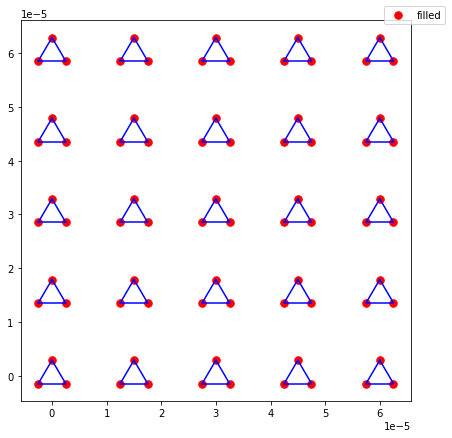

In [5]:
import numpy as np
from braket.ahs.atom_arrangement import AtomArrangement
from ahs_utils import show_register

separation = 5e-6
block_separation = 15e-6
k_max = 5
m_max = 5

register = AtomArrangement()
for k in range(k_max):
    for m in range(m_max):
        register.add((block_separation*m, block_separation*k + separation/np.sqrt(3)))
        register.add((block_separation*m-separation/2, block_separation*k - separation/(2*np.sqrt(3))))
        register.add((block_separation*m+separation/2, block_separation*k - separation/(2*np.sqrt(3))))        

show_register(register, show_atom_index=False, blockade_radius= 1.5 * separation)

In the above figure, each blue link connects a pair of atoms that blockade each other. Since the triangles are well separated from each other, and the driving field (see below) is acting on all atoms uniformly, effectively we are repeating the same experiment on the same setup (an equilateral triangle) 35 times in one shot. If the setup of interest is small and contains only a few atoms, we could try to fit in a few identical copies of the setup in the bounding box while avoiding the interference between them. In this way, we are effectively taking more shots for the AHS program of interest.

### Driving field

Recall that Aquila can simulate the following Hamiltonian 

\begin{align}
H(t) = \sum_{k=1}^N H_{\text{drive}, k}(t) + \sum_{j=1}^{N-1}\sum_{k = j+1}^N H_{\text{vdW}, j, k}.
\end{align}
Here the second term is the van der Waals interaction term which is fixed once the setup is defined. The first term is the driving field,
\begin{align}
H_{\text{drive}, k}(t) = \frac{\Omega(t)}{2}\left(e^{i\phi(t)}|g_k\rangle\langle r_k| + e^{-i\phi(t)}|r_k\rangle\langle g_k|\right) - \Delta_\text{global}(t)n_k,
\end{align}
which act on all the atoms in the setup. Here $n_k = |r_k\rangle\langle r_k|$ is the number operator of atom $k$.  The specification of the driving field has to satisfy several conditions, which can be queried as follows

In [6]:
rydberg = capabilities.rydberg
pp(rydberg.dict())

{'c6Coefficient': Decimal('5.42E-24'),
 'rydbergGlobal': {'detuningRange': (Decimal('-125000000.0'),
                                     Decimal('125000000.0')),
                   'detuningResolution': Decimal('0.2'),
                   'detuningSlewRateMax': Decimal('2500000000000000.0'),
                   'phaseRange': (Decimal('-99.0'), Decimal('99.0')),
                   'phaseResolution': Decimal('5E-7'),
                   'rabiFrequencyRange': (Decimal('0.0'),
                                          Decimal('15800000.0')),
                   'rabiFrequencyResolution': Decimal('400.0'),
                   'rabiFrequencySlewRateMax': Decimal('250000000000000.0'),
                   'timeDeltaMin': Decimal('1E-8'),
                   'timeMax': Decimal('0.000004'),
                   'timeMin': Decimal('0.0'),
                   'timeResolution': Decimal('1E-9')}}


`c6Coefficient` is the constant for the interaction strength between two Rydberg atoms. The detailed description for the `rydbergGlobal` section can be inspected as follows

In [7]:
print(rydberg.rydbergGlobal.__doc__)


    Parameters determining the limitations on the driving field that drives the
        ground-to-Rydberg transition uniformly on all atoms
    Attributes:
        rabiFrequencyRange (Tuple[Decimal,Decimal]): Achievable Rabi frequency
            range for the global Rydberg drive waveform (measured in rad/s)
        rabiFrequencyResolution (Decimal): Resolution with which global Rabi
            frequency amplitude can be specified (measured in rad/s)
        rabiFrequencySlewRateMax (Decimal): Maximum slew rate for changing the
            global Rabi frequency (measured in (rad/s)/s)
        detuningRange(Tuple[Decimal,Decimal]): Achievable detuning range for
            the global Rydberg pulse (measured in rad/s)
        detuningResolution(Decimal): Resolution with which global detuning can
            be specified (measured in rad/s)
        detuningSlewRateMax (Decimal): Maximum slew rate for detuning (measured in (rad/s)/s)
        phaseRange(Tuple[Decimal,Decimal]): Achievabl

As we can see, the requirements for the driving field in the AHS program can be summarized as follows

1. The Rabi frequency $\Omega(t)$ has to be within the range `rydberg.rydbergGlobal.rabiFrequencyRange`, in the unit of rad/s
2. The resolution for the Rabi frequency cannot be greater than `rydberg.rydbergGlobal.rabiFrequencyResolution` rad/s
3. The slew rate for the Rabi frequency cannot be greater than `rydberg.rydbergGlobal.rabiFrequencySlewRateMax` (rad/s)/s

4. The phase $\phi(t)$ has to be within the range `rydberg.rydbergGlobal.phaseRange`, in the unit of rad
5. The resolution for the phase cannot be greater than `rydberg.rydbergGlobal.phaseResolution` rad

6. The detuning $\Delta(t)$ has to be within the range `rydberg.rydbergGlobal.detuningRange`, in the unit of rad
7. The resolution for the detuning cannot be greater than `rydberg.rydbergGlobal.detuningResolution` rad
8. The slew rate for the detuning cannot be greater than `rydberg.rydbergGlobal.detuningSlewRateMax` rad/s

9. The duration of the driving field cannot be less than `rydberg.rydbergGlobal.timeMin` seconds
10. The duration of the driving field cannot be more than `rydberg.rydbergGlobal.timeMax` seconds
11. The time points have to be separated by at least `rydberg.rydbergGlobal.timeDeltaMin` seconds
12. The resolution for the time points cannot be greater than `rydberg.rydbergGlobal.timeResolution` seconds

Besides, there are a few additional requirements
1. The Rabi frequency $\Omega(t)$ has to start with 0 rad/s
2. The Rabi frequency $\Omega(t)$ has to end with 0 rad/s
3. The phase $\phi(t)$ has to start with 0 rad
4. All the fields in the driving field have to have the same duration

In this example, we are interested in driving the atoms with constant Rabi frequency $\Omega_\text{const}=1.5\times10^7$ rad/s for a duration of $T_\text{const}=\frac{\pi}{\sqrt{3}\Omega}\approx2.09\times10^{-7}$ seconds such that each atom has average Rydberg density equal to 1/3. Since the Rabi frequency corresponds to blockade radius $R_b\approx8.44\times10^{-6}$ meters, which is greater than the sides of the equilateral triangles ($5\times10^{-6}$ meters), the atoms of the same triangle blockade one another. On the other hand, $R_b$ is smaller than the distance between nearest atoms of neighboring triangles, which is around $10\times10^{-6}$ meters, hence the neighboring triangles are not interacting with each other, as desired. 

However, for the AHS program submitted to Aquila, the Rabi frequency cannot be a constant because of the constraint that it has to start and end with 0 rad/s. Hence we will need to create a time series $\Omega(t)$ such that $\int_0^T\Omega(t)dt=\Omega_\text{const}T_\text{const}=\frac{\pi}{\sqrt{3}}$, while satisfying $\Omega(0)=\Omega(T)=0$. This could be achieved via the utility function `rabi_pulse` below where we demonstrate how to create the desired driving field for Aquila.

In [8]:
from braket.timings.time_series import TimeSeries
from braket.ahs.driving_field import DrivingField
from ahs_utils import rabi_pulse, constant_time_series

omega_const = 1.5e7   # rad / s
rabi_pulse_area = np.pi/np.sqrt(3) # rad
omega_slew_rate_max = float(rydberg.rydbergGlobal.rabiFrequencySlewRateMax) # rad/s^2

time_points, amplitude_values = rabi_pulse(rabi_pulse_area, omega_const, 0.99 * omega_slew_rate_max)

amplitude = TimeSeries()
for t, v in zip(time_points, amplitude_values):
    amplitude.put(t, v)

detuning = constant_time_series(amplitude, 0.0) 
phase = constant_time_series(amplitude, 0.0) 

    
drive = DrivingField(
    amplitude=amplitude, 
    detuning=detuning, 
    phase=phase
)

We can inspect the driving field in the following way 

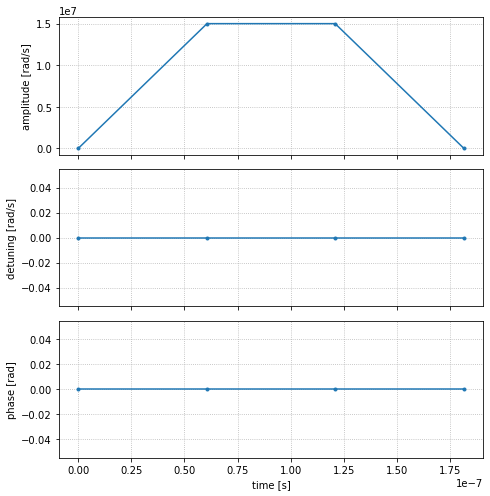

In [10]:
from ahs_utils import show_global_drive
show_global_drive(drive);

Here we used constant-zero phase and detuning, but, for more involved programs, its time series can be customized similarly to how we set the amplitude of the Rabi frequency here.

### AHS program

We can assemble the register and Hamiltonian to an AHS program 

In [10]:
from braket.ahs.hamiltonian import Hamiltonian
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation

ahs_program = AnalogHamiltonianSimulation(
    register=register, 
    hamiltonian=drive
)

### Task 

Before submitting the AHS program to Aquila, we need to discretize the program to ensure that it complies with resolution-specific validation rules. 

In [11]:
discretized_ahs_program = ahs_program.discretize(device)

We note that the number of shots has to be within the range specified by `device.properties.service.shotsRange`. 

In [12]:
device.properties.service.shotsRange

(1, 1000)

The AHS program can be submitted to the device to create a quantum task on the Braket service.

<div class="alert alert-block alert-info">
<b>Note: </b> Some atoms may be missing even if the shot was successful. We recommend comparing <code>pre_sequence</code> of each shot with the requested atom filling in the AHS program specification.  
</div>

In [13]:
n_shots = 100

In [14]:
task = device.run(discretized_ahs_program, shots=n_shots)

The task metadata can be inspected in the following way

In [17]:
metadata = task.metadata()
task_arn = metadata['quantumTaskArn']
task_status = metadata['status']

print(f"ARN: {task_arn}")
print(f"status: {task_status}")

ARN: arn:aws:braket:us-east-1:545821822555:quantum-task/f735c464-db7d-4511-9264-e83c5fb2b9b9
status: COMPLETED


It is suggested to save the task ARN for retrieving the task result in a later time. For example if the saved task ARN reads `arn:aws:braket:us-east-1:545821822555:quantum-task/12345`, the task can be retrieved as follows.
    
```
from braket.aws import AwsQuantumTask
task = AwsQuantumTask(arn="arn:aws:braket:us-east-1:545821822555:quantum-task/12345")    
```



Alternatively, we can access the tasks through [the tasks page of Amazon Braket console](https://us-east-1.console.aws.amazon.com/braket/home?region=us-east-1#/tasks).

## Analyzing the result from Aquila

The results (once the task is completed) can be downloaded directly into an object in the python session.

In [43]:
result = task.result()

The call `task.result()` is blocking execution until the task is completed and results are loaded from Amazon Braket. After the task is completed, the measurement result is saved in `result.measurements` which is a list of `ShotResult`, as shown below.

In [44]:
result.measurements[0]

ShotResult(status=<AnalogHamiltonianSimulationShotStatus.SUCCESS: 'Success'>, pre_sequence=array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), post_sequence=array([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))

`ShotResult` contains three pieces of information

1. `status` indicates if the shot is successful
2. `pre_sequence` contains the measurement result *before* running the AHS program. Here `0` indicates an empty site, while `1` indicates a filled site with an atom in the ground state
3. `post_sequence` contains the measurement result *after* running the AHS program. Here `0` indicates an empty site, or an atom in the Rydberg state, while `1` indicates an atom in the ground state


<div class="alert alert-block alert-info">
<b>Note: </b> Some atoms may be missing even if the shot was successful. We recommend comparing <code>pre_sequence</code> of each shot with the requested atom filling in the AHS program specification.  
</div>

To confirm that at the end of the AHS program, the average Rydberg density for the atoms in the triangles are around 1/3 for each atom, we can first collect the  measurement result and aggregate over all triangles

In [45]:
from ahs_utils import get_counts

counts = get_counts(result)
average_density = [0, 0, 0]
average_num_triangles = [0, 0, 0, 0]
for key, val in counts.items():
    for i in range(0, 3*k_max*m_max, 3):
        short_seq = key[i:i+3]
        for j in range(3):
            if short_seq[j]=="r":
                average_density[j] += val     
        
        
        average_num_triangles[short_seq.count('r')] += val
        
        
average_density = np.array(average_density) / (k_max * m_max * n_shots)
average_num_triangles = np.array(average_num_triangles) / n_shots

Note that although we only perform 100 shots for the given AHS program, since we have made the full usage of the area in the Aquila device, effectively, we have made 3,500 shots for the experiment of interest! We can plot the result as follows

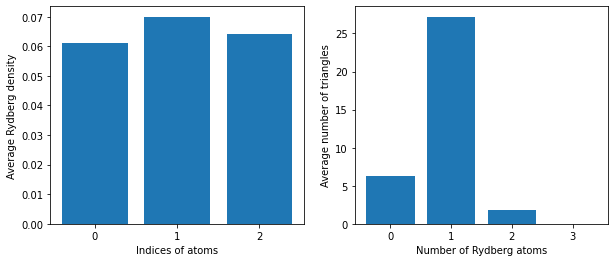

In [46]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.bar(range(len(average_density)), average_density)
ax1.set_xticks(range(3))
ax1.set_xticklabels(range(3))
ax1.set_xlabel("Indices of atoms")
ax1.set_ylabel("Average Rydberg density")

ax2.bar(range(len(average_num_triangles)), average_num_triangles)
ax2.set_xlabel("Number of Rydberg atoms")
ax2.set_ylabel("Average number of triangles")
plt.show()

In the left panel, we show the average Rydberg density for each atom in the triangles. We see that indeed the average Rydberg density for the atoms in the triangles are around 1/3 as expected. In the right panel, we show the number of triangles with certain number of Rydberg atoms (0, 1, 2 or 3) averaged over the shots. It is clear that none of the triangles have more than 1 Rydberg atoms since the atoms in the same triangle blockade each other. 

In summary, in this notebook we have demonstrated how to connect to QuEra's Aquila device, and define a valid AHS program for the device. 

In [ ]:
print("Task Summary")
print(tracker.quantum_tasks_statistics())
print('Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).')
print(f"Estimated cost to run this example: {tracker.qpu_tasks_cost() + tracker.simulator_tasks_cost():.2f} USD")